In [266]:
import numpy as np
import matplotlib.pyplot as plt     #plt.imshow para mostar imagens na tela
import imageio                      # imageio.imread e imageio.imsave para carregar e salvar imagens em .png
from scipy.signal import convolve2d


In [267]:
# cores básicas 
red   = (255,0,0)
green = (0,255,0)
blue  = (0,0,255)
black = (0,0,0)
white = (255,255,255)

# alguns filtros de convolução 
blurFilter = np.array(
    [
        [2, 4, 5, 4, 2],
        [4, 9, 12, 9, 4],
        [5, 12, 15, 12, 5],
        [4, 9, 12, 9, 4],
        [2, 4, 5, 4, 2]
    ]
)

# Filtro detector de borda
borderFilter = np.array(
     [
        [ 0, -8,  0],
        [-8, 16, -8],
        [ 0, -8,  0]
    ]
)

sobelFilter = np.array(
        [[47, 0,-47], 
         [162, 0, -162], 
         [47, 0, -47]]
)

# Desfoque de caixa ou Filtro Linear de Caixa; Filtro Passa Baixa de Raio 4, Matrix 9x9
# O parâmetro d deve ser preferencialmente ímpar; d >= 3
d = 3
boxBlurFilter = np.ones((d,d))


$PROGRAMA$ $PRINCIPAL$

In [268]:
def main():
    # leitura dos parâmetros
    in_Name1    = 'rodovia.jpg'#input('Nome do Arquivo de entrada:')
    in_Name2    = 'salt.png'#input('Nome do Arquivo de entrada:')
    out_Name   = 'saídaProvisória.jpg'#input('Nome do Arquivo na Saída:')
    threshold  = int(input('Limiar desejado (Número inteiro):'))
    radius     = int(input('Raio desejado para o Filtro de Mediana(Número inteiro):'))

    # carrega a imagem de entrada
    in_imag1 = Image() # entrada
    in_imag1.load(in_Name1) # carregamento da entrada

    in_imag2 = Image() # entrada
    in_imag2.load(in_Name2) # carregamento da entrada
    
    print('Imagem de Entrada...:', in_Name1)
    print('Imagem de Entrada...:', in_Name2)
    print('LIMIAR(threshold)...: ',threshold)
    print('Raio................: ',radius)
    
    original_imag1 = imageio.imread(in_Name1)
    original_imag2 = imageio.imread(in_Name2)
    
    # pré-processamento para segmentar as bordas
    gray = in_imag1.toGray() ################ 1 - FEITO ########
    gray2 = in_imag2.toGray()

    # imagem Binarizada
    rgbBin = in_imag1.binarize(threshold)


    #Mostra Imagens
    legenda = ['Imagem original','Imagem com níveis de Cinza','Imagem Binarizada']
    showImages([original_imag1,gray,rgbBin], legenda, (17,11), 3, 1)
    

    # normaliza os pesos dos filtros 
    blurKernel     = boxBlurFilter/boxBlurFilter.sum() ###################### borramento ###################
    sobelKernel    = sobelFilter#//(np.abs(sobelFilter).sum())
    detectorBordas = borderFilter#//(np.abs(borderFilter).sum())


    #borramento elimina as bordas que são menos intensas
    blurred = in_imag1.filterMean(gray, blurKernel) ###########   2 - FEITO    ########
    Sobel   = in_imag1.filterMean(gray, sobelKernel)
    bordas  = in_imag1.filterMean(gray, detectorBordas)
    legenda = ['Filtro Borramento ', 'Filtro Sobel',' Detector de Bordas']
    showImages([blurred, Sobel, bordas], legenda, (17,11), 3, 1)


    #Filtro de Mediana
    median = in_imag2.filterMedian(radius)
    plt.imshow(median,cmap='gray')
    # legenda = ['Imagem original', 'Filtro de Mediana']
    #showImages([original_imag2,median], legenda, (15,9), 2, 1)


    edges = blurred.segmentEdges(threshold) ######    3 - FALTA FAZER   #####
    print('Imagem das bordas Segmentadas: ')
    edges.show()


    #realce das bordas na imagem original
    painted = in_imag.paint(black, edges) ######   4 - FALTA FAZER   ###########
    print('Imagens com bordas realçadas')
    painted.show()


    # Salvar o resultado
    painted.saved(out_Name)
    print('A imagem realçada foi salva em', out_Name)




$Classe$ $Imagem$


In [269]:
class Image:
    
    #-----------------------------------------------------------------------------------------------------------
    
    def _init_(self, array = None): 
        #Construtor de um objeto Imagem, que recebe um array com o conteúdo da imagem.
        if array is not None:
            self.data = np.copy(array)
        else:
            self.data = None 

    def getpixel(self, lin, col): 
        # (self, inteiro, inteiro) >>> retorna o valor do pixel na posição (lin, col)
        return self.data[lin,col]

    def setpixel(self, lin, col, valor): 
        # (self, inteiro, inteiro) >>> atribui valor ao pixel na posição (lin, col)
        self.data[lin, col] = valor

    def load(self, file): 
        # (Str) >>> None; arquivo extensão .png
        self.data = imageio.imread(file)

    def saved(self, file):
         # (Str) >>> None; Aqui também será salvo em extensão .png
        imageio.imsave(file,self.data)

    #-----------------------------------------------------------------------------------------------------------
    
    def toGray(self): 

        rgb = self.data

        
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = (0.2126 * r) + (0.7152 * g) + (0.0722 * b)

        return gray
        
    #-----------------------------------------------------------------------------------------------------------
    
    def binarize(self, threshold): 
        # (self, inteiro) >>> retorna uma imagem convertida para binário. 
        rgbBin = self.data
        for row in range(0, rgbBin.shape[0]):
            for col in range(0, rgbBin.shape[1]):
                if (rgbBin[row][col] <= threshold).any():
                    rgbBin[row,col] = (0,0,0)
                else:
                    rgbBin[row,col] = (255,255,255)
                
        return rgbBin
    
    #-----------------------------------------------------------------------------------------------------------
    
    def filterMean(self,gray, filter_): 
        # (self, ndarray) >>> Imagem Cinza. Este Método retorna uma imagem da convolução de Self com o filtro.
        # Como os valores do filtro são reais, os valores da imagem resultado também serão reais.
        A = gray
        B = filter_
        imFiltered = convolve2d(A,B)
        return imFiltered

    #-----------------------------------------------------------------------------------------------------------    

    def filterMedian(self,filterSize):
        #(self, int) >>> Imagem Cinza. Este Método retorna uma imagem filtrada com uma matrix de mediana
        gray = imageio.imread('noise.png')
        temp = []
        indexer = filterSize//2
        dataFinal = []
        dataFinal = np.zeros((len(gray),len(gray[0])))
        for i in range(len(gray)):
            for j in range(len(gray[0])):
                for z in range (filterSize):
                    if ((i+z-indexer)<0) |( (i+z-indexer) > (len(gray)-1)):
                        for c in range(filterSize):
                            temp.append(0)
                    else:
                        if (((j+z-indexer)<0 ) | (j+z-indexer>(len(gray[0])-1))):
                            temp.append(0)
                        else:
                            for k in range(filterSize):
                                temp.append(gray[i+z-indexer][j+k-indexer])

                temp.sort()
                dataFinal[i][j] = temp[len(temp)//2]
                temp = []
        return dataFinal
        
    #-----------------------------------------------------------------------------------------------------------
    
    #def paint(self, color, mask): 
        # (self, cor, Imagem) >>> Imagem; Recebe uma imagem binária e pinta os pixels de self correspondentes aos pixels Trfue da mascara com a cor.
        # Obeservar  que a cor  deve ter o mesmo numero de bits da imagem em self.
    
    #-----------------------------------------------------------------------------------------------------------
    
    #def segmentEdges(self, threshold): 
        """Assumir que self é uma imagem com níveis de cinza. 
        O método calcula as matrizes gradiente gH e gV
        utilizando os filtros Sh e Sv de Sobel, e retorna uma imagem 
        binária com as mesmas dimensões da imagem cinza self, 
        onde os valores True satisfazem:
        sqrt(gH*gH + gV*gV) > limiar.
        Pixels que não satisfazem a condições devem receber False.

        Importante: como o limiar é um número entre 0 e 255,
        antes de aplicar o limiar (comparar), a imagem correspondente ao 
        módulo do gradiente (sqrt(gH*gH + gV*gV)) deve ser normalizada para
        o intervalo 0 a 255."""
        

$Métodos$ $apenas$ $para$ $exibição$ $de$ $imagens$ 

In [270]:
def showImage(imag, title, size):
    fig, axis = plt.subplots(figsize = size)

    axis.imshow(imag,'gray')
    axis.set_title(title, fontdict = {'fontsize':22,'fontweight':'medium'})
    plt.show()

def showImages(imagArray,titleArray, size, x,y):
    if(x<1 | y<1):
        print('ERRO: x e y não podem ser zero ou abaixo de zero.')
        return
    elif(x==1 & y==1):
        showImage(imagArray, titleArray)
    elif(x==1):
        fig, axis = pltsubplots(y, figsize = size)
        yId = 0
        for imag in imagArray:
            axis[yId].imshow(imag,'gray')
            axis[yId].set_anchor('NW')
            axis[yId].set_title(titleArray[yId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            yId += 1

    elif(y ==1):
        fig, axis = plt.subplots(1,x,figsize = size)
        fig.suptitle(titleArray)
        xId = 0
        for imag in imagArray:
            axis[xId].imshow(imag,'gray')
            axis[xId].set_anchor('NW')
            axis[xId].set_title(titleArray[xId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)

            xId += 1

    else:
        fig, axis = plt.subplots(y,x,figsize =size)
        xId, yId, titleId = (0,0,0)
        for imag in imagArray:
            axis[yId,xId].imshow(imag,'gray')
            #axis[yId,xId].set_anchor('NW')
            axis[yId,xId].set_title(titleArray[titleId], fontdict = {'fontsize': 18, 'fontweight': 'medium'}, pad = 10)
            if len(titleArray[titleId])==0:
                axis[yId,xId].axis('off')

            titleId += 1
            xId += 1
            if xId == x:
                xId = 0
                yId += 1
    plt.show()

$Execução$ $da$ $Main$

Imagem de Entrada...: rodovia.jpg
Imagem de Entrada...: salt.png
LIMIAR(threshold)...:  200
Raio................:  3


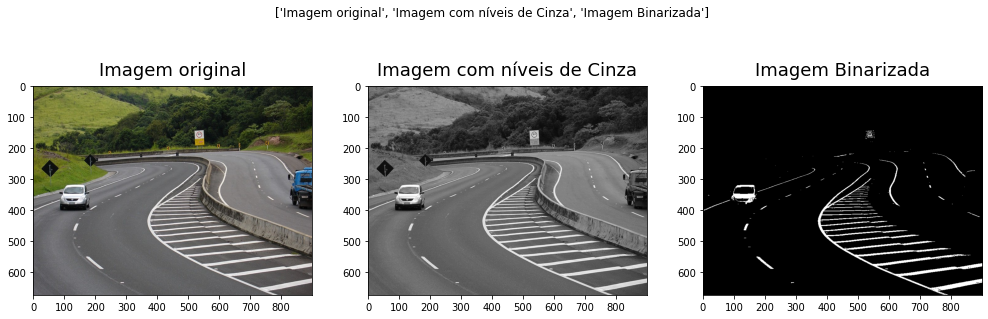

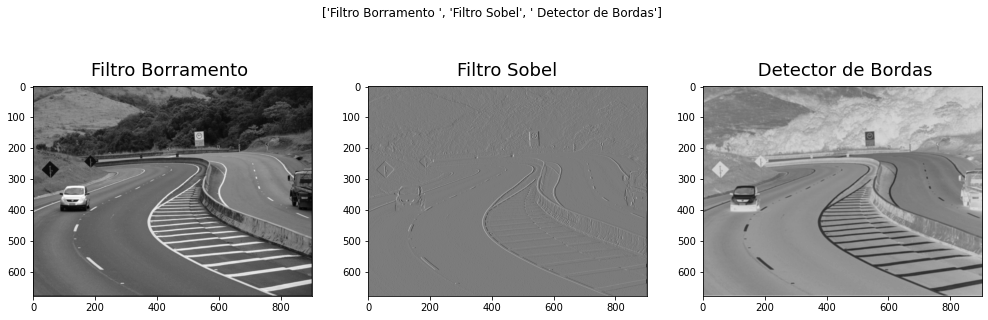

IndexError: index 256 is out of bounds for axis 0 with size 256

In [271]:
if __name__ == '__main__':
    main()